# Test file

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import logging
from hms.layers import AffineLayer, SoftmaxLayer, SigmoidLayer
from hms.errors import CrossEntropyError, CrossEntropySoftmaxError, SumOfSquaredDiffsError
from hms.models import SingleLayerModel, MultipleLayerModel
from hms.initialisers import UniformInit, GlorotUniformInit
from hms.learning_rules import GradientDescentLearningRule
from hms.data_providers import HMSDataProvider
from hms.optimisers import Optimiser
%matplotlib inline
plt.style.use('ggplot')

# Seed a random number generator
seed = 6102016 
rng = np.random.RandomState(seed)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = HMSDataProvider('train', rng=rng)
valid_data = HMSDataProvider('valid', rng=rng)
input_dim, output_dim = 25, 6

In [13]:
def train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval):

    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

    optimiser = Optimiser(
        model, error, learning_rule, train_data, valid_data, data_monitors)

    stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')

#     # Plot the change in the validation and training set accuracy over training.
#     fig_2 = plt.figure(figsize=(8, 4))
#     ax_2 = fig_2.add_subplot(111)
#     for k in ['acc(train)', 'acc(valid)']:
#         ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
#                   stats[1:, keys[k]], label=k)
#     ax_2.legend(loc=0)
#     ax_2.set_xlabel('Epoch number')
    
    return stats, keys, run_time, fig_1, ax_1

Epoch Progress: 100%|██████████| 122/122 [00:00<00:00, 4765.41it/s]Epoch 5: 0.0s to complete
    error(train)=1.15e-01, acc(train)=9.91e-01, error(valid)=8.77e-03, acc(valid)=2.31e-01

Epoch Progress: 100%|██████████| 122/122 [00:00<00:00, 5313.88it/s]Epoch 10: 0.0s to complete
    error(train)=1.02e-01, acc(train)=9.91e-01, error(valid)=7.63e-03, acc(valid)=2.31e-01
Epoch Progress: 100%|██████████| 122/122 [00:00<00:00, 4249.83it/s]Epoch 15: 0.0s to complete
    error(train)=9.15e-02, acc(train)=9.91e-01, error(valid)=7.24e-03, acc(valid)=2.31e-01

Epoch Progress: 100%|██████████| 122/122 [00:00<00:00, 4714.05it/s]Epoch 20: 0.0s to complete
    error(train)=8.19e-02, acc(train)=9.91e-01, error(valid)=7.46e-03, acc(valid)=2.32e-01
Epoch Progress: 100%|██████████| 122/122 [00:00<00:00, 4032.13it/s]Epoch 25: 0.0s to complete
    error(train)=7.33e-02, acc(train)=9.92e-01, error(valid)=8.21e-03, acc(valid)=2.32e-01

Epoch Progress: 100%|██████████| 122/122 [00:00<00:00, 4177.12it/s]Epoch 

Epoch Progress: 100%|██████████| 122/122 [00:00<00:00, 4528.36it/s]Epoch 60: 0.0s to complete
    error(train)=3.56e-02, acc(train)=9.91e-01, error(valid)=2.18e-02, acc(valid)=2.32e-01
Epoch Progress: 100%|██████████| 122/122 [00:00<00:00, 4725.58it/s]Epoch 65: 0.0s to complete
    error(train)=3.24e-02, acc(train)=9.91e-01, error(valid)=2.43e-02, acc(valid)=2.32e-01

Epoch Progress: 100%|██████████| 122/122 [00:00<00:00, 5236.71it/s]Epoch 70: 0.0s to complete
    error(train)=2.95e-02, acc(train)=9.91e-01, error(valid)=2.68e-02, acc(valid)=2.32e-01
Epoch Progress: 100%|██████████| 122/122 [00:00<00:00, 4246.13it/s]Epoch 75: 0.0s to complete
    error(train)=2.70e-02, acc(train)=9.91e-01, error(valid)=2.93e-02, acc(valid)=2.32e-01

Epoch Progress: 100%|██████████| 122/122 [00:00<00:00, 4710.97it/s]Epoch 80: 0.0s to complete
    error(train)=2.48e-02, acc(train)=9.91e-01, error(valid)=3.18e-02, acc(valid)=2.32e-01
Epoch Progress: 100%|██████████| 122/122 [00:00<00:00, 5029.44it/s]Epoch 

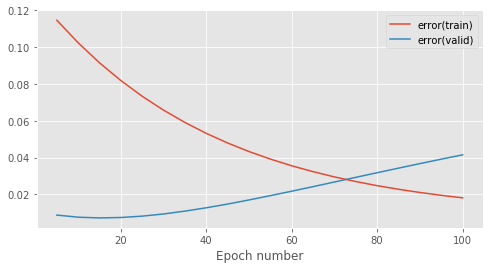

In [9]:
# Set training run hyperparameters
batch_size = 100  # number of data points in a batch
init_scale = 0.00001  # scale for random parameter initialisation
learning_rate = 0.0001  # learning rate for gradient descent
num_epochs = 100  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats
hidden_dim = 12

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Alter data-provider batch size
train_data.batch_size = batch_size 
valid_data.batch_size = batch_size

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]
param_init = UniformInit(-init_scale, init_scale, rng=rng)

# Create affine + softmax model
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, param_init, param_init),

    AffineLayer(hidden_dim, output_dim, param_init, param_init),
])

# Initialise a cross entropy error object
error = SumOfSquaredDiffsError()

# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

stats, keys, run_time, fig_1, ax_1 = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval)

In [10]:
stats

array([[ 0.12857136,  0.99139344,  0.01082383,  0.23138462],
       [ 0.11469814,  0.99139344,  0.00877394,  0.23130769],
       [ 0.10241177,  0.99139344,  0.0076268 ,  0.23138462],
       [ 0.09152582,  0.99139344,  0.00723503,  0.23138462],
       [ 0.08188391,  0.99147541,  0.00746181,  0.23169231],
       [ 0.07333224,  0.99155738,  0.00820622,  0.23153846],
       [ 0.06578435,  0.99139344,  0.00939517,  0.23161538],
       [ 0.05910975,  0.99139344,  0.01093442,  0.23161538],
       [ 0.05317276,  0.99139344,  0.0127518 ,  0.23161538],
       [ 0.04795456,  0.99139344,  0.01478098,  0.23161538],
       [ 0.04330593,  0.99147541,  0.01700547,  0.23161538],
       [ 0.03920746,  0.99139344,  0.01935636,  0.23138462],
       [ 0.03556128,  0.99139344,  0.02176772,  0.23176923],
       [ 0.03237869,  0.99139344,  0.02425235,  0.23207692],
       [ 0.02951508,  0.99147541,  0.02676695,  0.23184615],
       [ 0.02699898,  0.99139344,  0.02930705,  0.23161538],
       [ 0.02475627,  0.

In [11]:
keys

{'acc(train)': 1, 'acc(valid)': 3, 'error(train)': 0, 'error(valid)': 2}